In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str,
    pd_display_all
)

In [3]:
wmf.charting.set_mpl_style()

## Data caveats
* The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.
* After the scheduled publication of recommendations on 2 June at 03:00 UTC, an infrastructure issue prevented new recommendations from being published (although the existing recommendations continued to be served to app users). The issue was fixed and updated set of recommendations were published on 4 June at 23:00 UTC, followed by scheduled updates as normal.
* There was a significant break in the trending articles job, from 6 October through 20 October (the trending articles from 5 October continued to be displayed during this period).

The drop in events starting on 29 August is expected, since that's when KaiOS stopped running ads for our app in their ad network.

## Initial data exploration

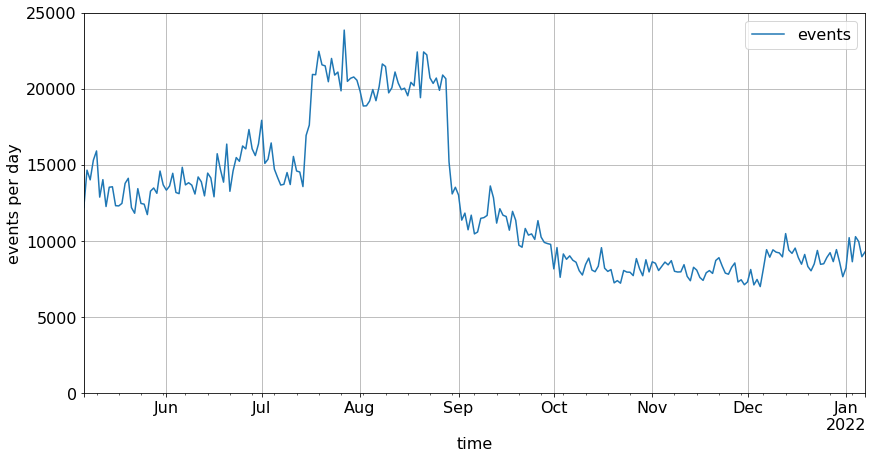

In [6]:
experiment_events = wmf.presto.run("""
    SELECT
        DATE(server_dt) AS time,
        COUNT(*) AS events
    FROM nshahquinn.kaios_experiment_event_combined
    GROUP BY DATE(server_dt)
    ORDER BY time
""").set_index("time")

experiment_events.plot(
    ylim=(0, 25_000),
    ylabel="events per day"
);

In [13]:
wmf.presto.run("""
SELECT
    country IN ('NG', 'PK', 'TZ', 'UG') as focus_country,
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY country IN ('NG', 'PK', 'TZ', 'UG')
""")

,focus_country,events,users
0,True,1612479,116355
1,False,1502869,51353


In [14]:
wmf.presto.run("""
SELECT
    app_version,
    COUNT(*) AS events
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY app_version
""")

,app_version,events
0,1.7.0.0,224
1,1.6.0,3114407
2,0.0.0,555
3,1.8.1.0,162


In [15]:
user_agg = wmf.presto.run("""
SELECT
    user_id,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
    ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY user_id
""")

In [16]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167604 entries, 0 to 167603
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           167604 non-null  object
 1   country           167604 non-null  object
 2   experiment_group  167604 non-null  object
 3   wiki              167604 non-null  object
dtypes: object(4)
memory usage: 5.1+ MB


In [17]:
focus_users_all_wikis = (
    user_agg
    .query(
        "country in ('NG', 'PK', 'TZ', 'UG') "
        "and experiment_group in ('control', 'trending-articles')"
    )
)

In [18]:
focus_users_all_wikis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116248 entries, 2 to 167603
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           116248 non-null  object
 1   country           116248 non-null  object
 2   experiment_group  116248 non-null  object
 3   wiki              116248 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [19]:
(
    focus_users_all_wikis
    .groupby('wiki')
    .size()
    .sort_values(ascending=False)
    .head(20)
)

wiki
                 54560
enwiki           53678
enwiki-           2223
swwiki             699
enwiki-swwiki      522
swwiki-enwiki      508
enwiki-dewiki      389
urwiki             323
enwiki-urwiki      306
urwiki-enwiki      228
enwiki-frwiki      149
enwiki-eswiki      136
frwiki             136
nlwiki-enwiki      125
enwiki-nlwiki      120
nlwiki             116
enwiki-itwiki      100
dewiki-enwiki       86
enwiki-afwiki       86
swwiki-             75
dtype: int64

* Remove entire users if they switch countries or groups

In [20]:
user = wmf.presto.run(f"""
WITH pageview AS (
    SELECT
        pageview_id,
        session_id,
        user_id,
        MIN(server_dt) AS start_time,
        MAX(
            -- Convert milliseconds to minutes
            CAST(page_visible_time AS REAL) / 1000 / 60
        ) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM nshahquinn.kaios_experiment_event_combined
    WHERE
        app_version = '1.6.0'
    GROUP BY
        pageview_id,
        session_id,
        user_id
), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM pageview
    GROUP BY
        user_id,
        session_id
), user AS (
    SELECT
        user_id,
        MIN(start_time) AS experiment_entry,
        CAST(DATE_DIFF('second', MIN(start_time), CURRENT_TIMESTAMP) AS REAL) / 60 / 60 / 24  AS days_in_experiment,
        COUNT(1) AS sessions,
        AVG(page_viewing_min) AS mean_session_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM session
    GROUP BY user_id
)
SELECT
    user_id,
    experiment_entry,
    days_in_experiment,
    sessions,
    mean_session_min,
    country,
    wiki,
    experiment_group
FROM user
WHERE
    country IN ('NG', 'PK', 'TZ', 'UG')
    AND experiment_group IN ('control', 'trending-articles')
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category"),
    wiki=lambda df: df["wiki"].astype("category")
)

In [21]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116248 entries, 0 to 116247
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             116248 non-null  object        
 1   experiment_entry    116248 non-null  datetime64[ns]
 2   days_in_experiment  116248 non-null  float64       
 3   sessions            116248 non-null  int64         
 4   mean_session_min    116248 non-null  float64       
 5   country             116248 non-null  category      
 6   wiki                116248 non-null  category      
 7   experiment_group    116248 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.9+ MB


# Data exploration

## Users by countries and experiment groups

In [22]:
pd.pivot_table(
    user,
    # The column used for `values` means nothing since we use `len` as the `aggfunc`.
    values="user_id",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

experiment_group,control,trending-articles,All
country,,,
NG,7788,7743,15531
PK,25063,24797,49860
TZ,18122,18142,36264
UG,7305,7288,14593
All,58278,57970,116248


## Session duration

In [23]:
user["mean_session_min"].describe()

count    116248.000000
mean         10.236042
std        1003.680567
min        -533.543760
25%           0.401006
50%           1.135983
75%           2.580542
max      252486.750000
Name: mean_session_min, dtype: float64

In [24]:
with pd.option_context("display.min_rows", 30):
    display(user["mean_session_min"].sort_values(ascending=False))

11663     252486.750000
58473     110552.320000
68972     101221.140000
106255     89552.820000
80164      89305.610000
8597       88719.090000
2303       49893.125000
43793      39641.605000
71114      39428.207000
4952       32997.098000
27736      12894.256000
43364      12634.044000
86302        396.418600
63047        173.118800
9474         123.104260
              ...      
91575          0.002267
43530          0.002267
115850         0.002250
76594          0.002117
50146          0.002067
114033         0.002067
72556          0.002050
25812          0.001900
17152          0.001167
79410          0.001117
47856          0.000950
49253          0.000883
109086        -0.015567
26307         -0.748583
82733       -533.543760
Name: mean_session_min, Length: 116248, dtype: float64

Some users have pathological session lengths. Let's remove them.

In [25]:
user = user.query("mean_session_min >= 0 and mean_session_min < 600")

In [26]:
user["mean_session_min"].describe()

count    116233.000000
mean          2.332622
std           4.274638
min           0.000883
25%           0.401000
50%           1.135475
75%           2.579217
max         396.418600
Name: mean_session_min, dtype: float64

In [27]:
# Proportion of users with mean session length of 10 minutes or more
print(pct_str(user["mean_session_min"][lambda x: x >= 10].pipe(len) / len(user)))

3.7%


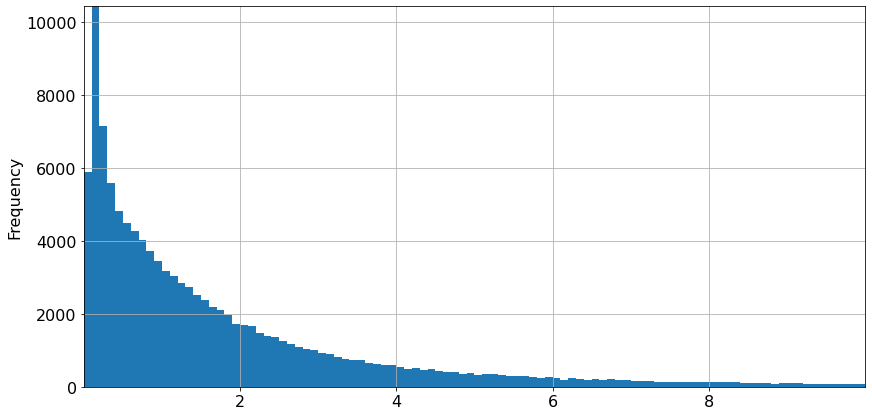

In [28]:
user["mean_session_min"][lambda x: x < 10].plot(kind='hist', bins=100);

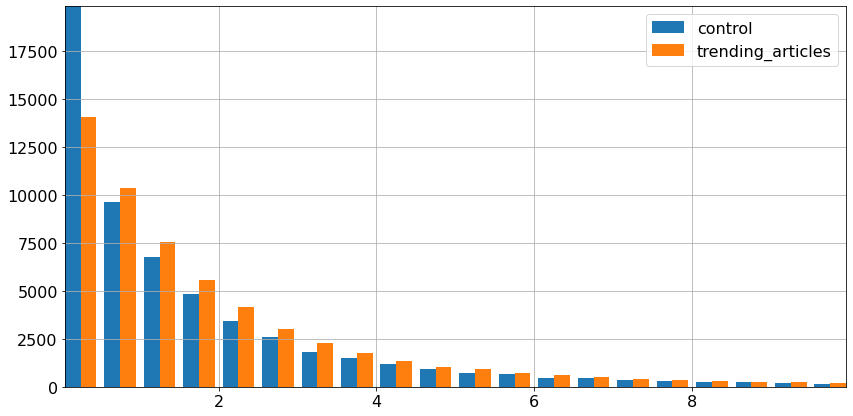

In [29]:
control_session_lengths = user.query("experiment_group == 'control'")["mean_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["mean_session_min"][lambda x: x <= 10]

plt.hist([
    control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

## Session count

In [30]:
user["sessions"].describe()

count    116233.000000
mean          2.147987
std           3.830685
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         321.000000
Name: sessions, dtype: float64

In [31]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

1.5%


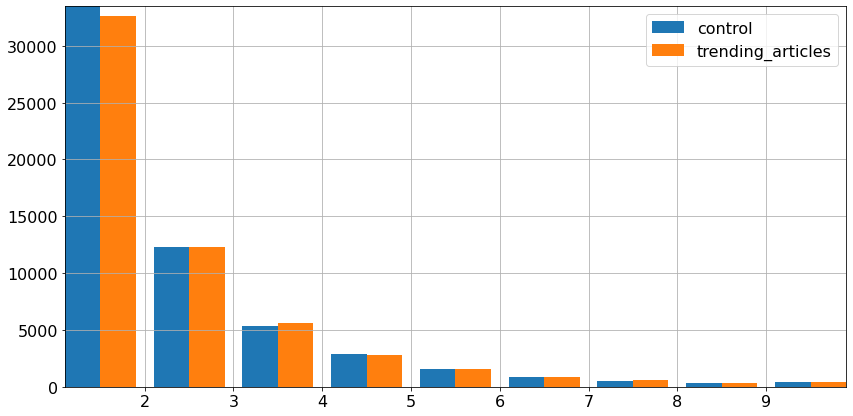

In [32]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [33]:
user["experiment_entry"].describe(datetime_is_numeric=True)

count                           116233
mean     2021-07-21 20:53:46.506426368
min         2021-05-06 00:00:00.350000
25%         2021-06-09 17:43:54.008000
50%         2021-07-14 07:44:53.652000
75%         2021-08-15 18:04:24.988000
max         2022-01-06 23:24:30.047000
Name: experiment_entry, dtype: object

In [34]:
user["days_in_experiment"].describe()

count    116233.000000
mean        169.245829
std          56.321548
min           0.141157
25%         144.363430
50%         176.793690
75%         211.377690
max         246.116520
Name: days_in_experiment, dtype: float64

## Correlations

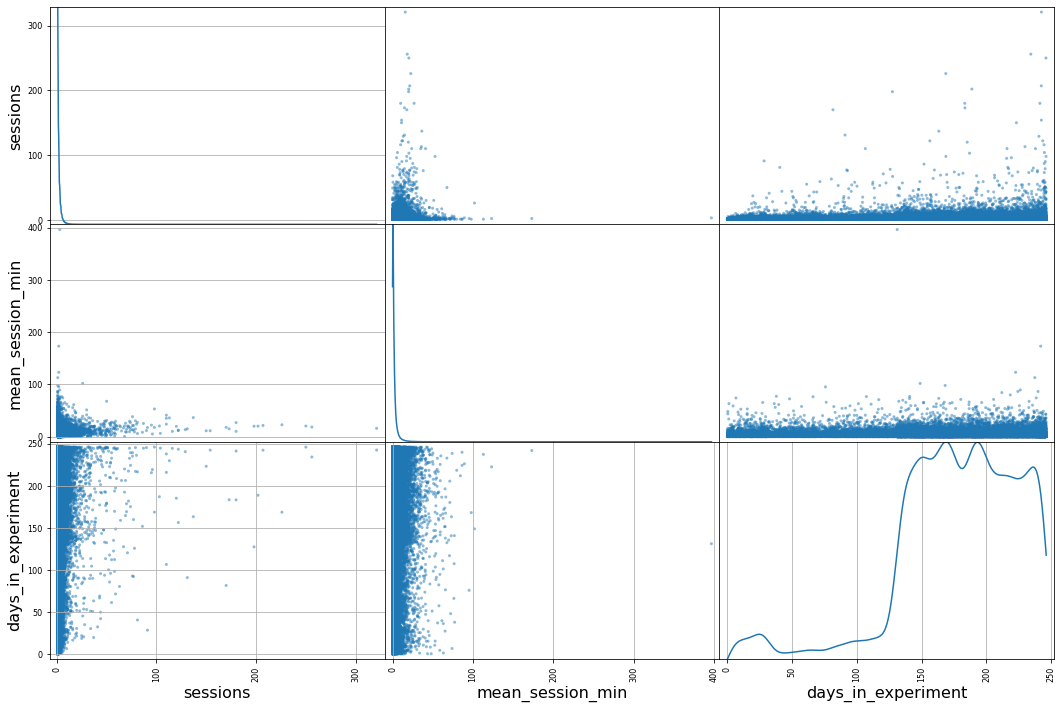

In [35]:
pd.plotting.scatter_matrix(
    user[["sessions", "mean_session_min", "days_in_experiment"]],
    diagonal="kde",
    figsize=(18, 12)
);

In [36]:
user.corr()

,days_in_experiment,sessions,mean_session_min
days_in_experiment,1.000000,0.039110,-0.036115
sessions,0.039110,1.000000,0.201052
mean_session_min,-0.036115,0.201052,1.000000


In [37]:
# We should actually save this as a timestamped file, so we can cleanly replicate the analysis
user.to_parquet('data/2022-01-06_experiment_user.parquet')